In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [136]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
rcParams.update({'font.size': 22})

In [151]:
df = pd.read_csv("cleaned_data.csv")

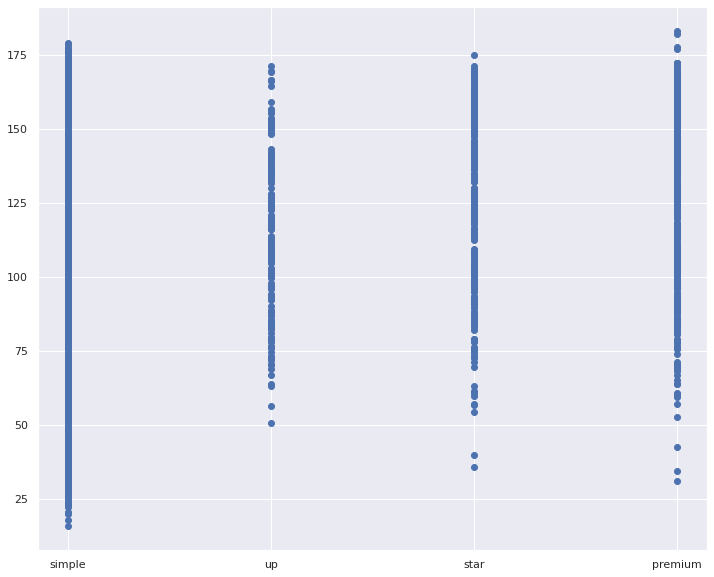

In [138]:
plt.scatter(df['ad_type'], df['ranking_score']);

In [139]:
df[['id', 'ad_type']].groupby('ad_type').count()

,id
ad_type,
premium,446
simple,14413
star,280
up,165


I plotted the distributions of ranking scores in order to see what summary statistic I should use. The distributions were a bit skewed thus I chose median instead of mean.

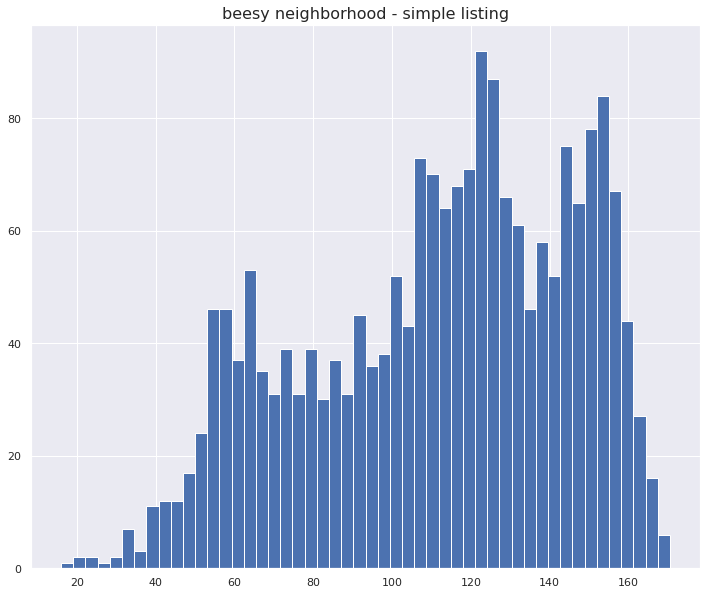

In [153]:
plt.hist(df['ranking_score'][(df['geography_name'] == 'beesy neighborhood') & (df['ad_type'] == 'simple')], bins=50)
plt.title('beesy neighborhood - simple listing', fontsize=16);

After I grouped by the data by geography name and ad_type, I added two more columns, one that counts the records of each categpry and another one that contains the ranking median. 

To measure the *competitiveness* of each area of each level, I multiplied the $ad\_type^4$ with the count of all the upper levels and I added the count multiplied with the median of my current level. The main idea behind this is that I wanted to weight the upper levels somehow, as the upper there are the more competitive there are, and also the more each level has they are the more competitive it is. I didn't take into account the median rankings of the upper levels because they won't affect my ranking. For example, if I am a new user and I want to enter to SpaN with a simple listing I will have to compete only the rankings of the other simple listings and not those of the star, the up or the premium.

In [141]:
def summary_stats(x):
    d = {}
    d['count'] = x['id'].count()
    d['ranking_median'] = x['ranking_score'].median()
    return pd.Series(d, index=['count', 'ranking_median'])

df = df.replace(['star', 'premium', 'up', 'simple'], [1, 2, 3, 4])
area_type = df[['geography_name', 'ad_type', 'id', 'ranking_score']].groupby(['geography_name', 'ad_type']).apply(summary_stats)

In [142]:
sub_df = area_type.reset_index(level=[0,1])
sub_df

,geography_name,ad_type,count,ranking_median
0,beesy neighborhood,1,30.0,119.35
1,beesy neighborhood,2,44.0,121.75
2,beesy neighborhood,3,34.0,113.10
3,beesy neighborhood,4,2033.0,116.80
4,gentrification area,1,17.0,145.50
5,gentrification area,2,36.0,145.70
6,gentrification area,3,15.0,148.20
7,gentrification area,4,758.0,122.80
8,northern sub,1,138.0,124.40
9,northern sub,2,205.0,144.00


In [143]:
sub_df = area_type.reset_index(level=[0,1])
sub_df['competitiveness'] = 0.0
for i, row in sub_df.iterrows():
    geo = row['geography_name']
    geo_new = geo
    j = 1
    competitiveness = 0
    while geo == geo_new and row['ad_type'] != 1 and 0 <= j <= i:
        competitiveness +=  (5 - sub_df['ad_type'][i-j])**4 *sub_df['count'][i-j]
        j += 1
        if i-j < 0: break
        geo_new = sub_df['geography_name'][i-j]
        
    sub_df['competitiveness'][i] = (competitiveness + sub_df['count'][i]*sub_df['ranking_median'][i])/1000

<ipython-input-143-5e98033fad3b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['competitiveness'][i] = (competitiveness + sub_df['count'][i]*sub_df['ranking_median'][i])/1000


In [144]:
sub_df

,geography_name,ad_type,count,ranking_median,competitiveness
0,beesy neighborhood,1,30.0,119.35,3.5805
1,beesy neighborhood,2,44.0,121.75,13.0370
2,beesy neighborhood,3,34.0,113.10,15.0894
3,beesy neighborhood,4,2033.0,116.80,249.2424
4,gentrification area,1,17.0,145.50,2.4735
5,gentrification area,2,36.0,145.70,9.5972
6,gentrification area,3,15.0,148.20,9.4910
7,gentrification area,4,758.0,122.80,100.5904
8,northern sub,1,138.0,124.40,17.1672
9,northern sub,2,205.0,144.00,64.8480


In [145]:
sub_df.groupby('geography_name')['competitiveness'].sum().reset_index()

,geography_name,competitiveness
0,beesy neighborhood,280.9493
1,gentrification area,122.1521
2,northern sub,761.5644
3,south beach,999.4474


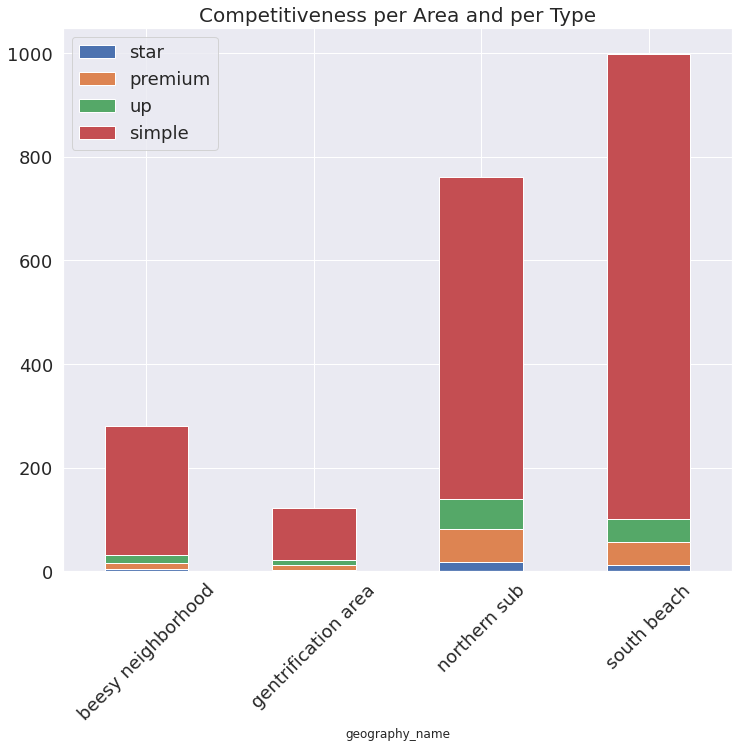

In [146]:
fig, ax = plt.subplots()
df2 = sub_df.groupby(['geography_name', 'ad_type'])['competitiveness'].sum().unstack('ad_type')
df2.plot(kind='bar', stacked=True,  fontsize=18, rot=45, ax=ax)
ax.legend(['star', 'premium', 'up', 'simple'], fontsize=18)
ax.set_title('Competitiveness per Area and per Type', fontsize=20);